In [1]:
import pandas as pd
import numpy
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import sys
sys.path.append("..")
from utils import pad_collate
from dataloader_comma import CommaDataset
from dataloader_nuscenes import NUScenesDataset
from collections import Counter
from model import VTN
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import os
from utils import * 
import re
from vis_utils import * 


/home/jessica/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using concept features


In [2]:
from scipy.signal import find_peaks

/tmp/ipykernel_2625842/3336085971.py:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binary_array = np.zeros(len(m), dtype=np.int)
/tmp/ipykernel_2625842/3336085971.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top5_indices = torch.tensor(attention_concepts).topk(5).indices


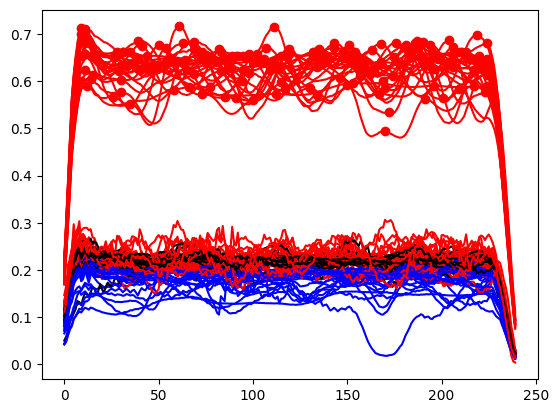

In [9]:
all_f = []
for j, batch in enumerate(dataloader_comma):
    img, vego, angle, distance, gas, brake, ccenabled = batch

    intervention = ~ccenabled.squeeze() | brake.squeeze() | gas.squeeze()

    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    img, vego, angle, distance, gas, brake, ccenabled = img, vego.squeeze(), angle.squeeze(), distance.squeeze(), gas.squeeze(), brake.squeeze(), ccenabled.squeeze()
    angle, distance, vego, logits = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu")

    atten = attns[0][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_0 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_0 = moving_average(speed_graph_0, 10)

    atten = attns[1][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_1 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_1 = moving_average(speed_graph_1, 10)

    atten = attns[2][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_2 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_2 = moving_average(speed_graph_2, 10)
    
    f = []
    inter = []
    m = (speed_graph_2 + speed_graph_1 + speed_graph_0)
    plt.plot(speed_graph_2, color="black")
    plt.plot(speed_graph_1, color ="blue")
    plt.plot(speed_graph_0, color ="red")
    ali = 1 + m 
    concepts = concepts.squeeze()
    weighted_concepts = concepts.cpu() * ali.reshape((ali.shape[0],1))
   
    smoothed_signal = np.convolve(m, np.ones(8) / 8, mode='same')
    peaks, _ = find_peaks(smoothed_signal, distance=16)

    # Plot original and smoothed signals
    plt.plot(peaks, smoothed_signal[peaks], 'ro', label='Peaks')
    plt.plot(smoothed_signal, 'r-')
    binary_array = np.zeros(len(m), dtype=np.int)
    


    for elem in peaks:
        binary_array[max(0, elem-4): min(len(m), elem+4)] = 1
    binary_array = (smoothed_signal-smoothed_signal.mean()) < 0.1
    attention_concepts = concepts.squeeze()[binary_array == 1, :]
    top5_indices = torch.tensor(attention_concepts).topk(5).indices
    for i, elem0 in enumerate(top5_indices):
        for a in elem0: 
            f.append(scenarios)
    all_f.extend(f)
    
    

In [10]:
flattened = []
for f in all_f: 
    flattened.extend(f)

In [11]:
a = np.unique(np.array(flattened))
c = Counter(np.array(flattened))

In [8]:
mc = c.most_common(6)
mc

[('a photo of a street with many pedestrians', 820),
 ('a photo of a street with a truck', 615),
 ('a photo of a street with a Parking lot', 615),
 ('a photo of a street while waiting at intersection', 615),
 ('a photo of driving on a highway with a car in front changing lanes', 410),
 ('a photo of driving on a highway with a motorcycle passing by in the opposite direction',
  410)]

In [12]:
mc = c.most_common(6)
mc

[('a photo of a street with many pedestrians', 119180),
 ('a photo of a street with a truck', 89385),
 ('a photo of a street with a Parking lot', 89385),
 ('a photo of a street while waiting at intersection', 89385),
 ('a photo of driving on a highway with a car in front changing lanes', 59590),
 ('a photo of driving on a highway with a motorcycle passing by in the opposite direction',
  59590)]

In [2]:

for j, batch in enumerate(dataloader_comma):
    _, img, vego, angle, distance, gas, brake, ccenabled = batch

    img, angle, distance, vego = img.to(gpu), angle.to(gpu), distance.to(gpu), vego.to(gpu)
    (logits, attns), concepts = model(img, angle, distance, vego)
    img, vego, angle, distance, gas, brake, ccenabled = img, vego.squeeze(), angle.squeeze(), distance.squeeze(), gas.squeeze(), brake.squeeze(), ccenabled.squeeze()
    logits, attns = logits.squeeze(), attns.squeeze()
    attns = attns[ccenabled]
    angle, distance, vego, logits = angle.to("cpu"), distance.to("cpu"), vego.to("cpu"), logits.detach().cpu().to("cpu")

    concepts
    atten = attns[0][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_0 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_0 = moving_average(speed_graph_0, 10)

    atten = attns[1][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_1 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_1 = moving_average(speed_graph_1, 10)

    atten = attns[2][:,:,0:concepts.shape[1]].detach()
    seq_len = atten.shape[2]
    alignment_array = get_aligned_attention(atten.squeeze().cpu(), seq_len)
    speed_graph_2 = alignment_array.sum(axis=0)[8:-8]
    speed_graph_2 = moving_average(speed_graph_2, 10)
    
    f = []
    inter = []
    m = (speed_graph_2 + speed_graph_1 + speed_graph_0)/3
    ali = 1 + m 
    print(ali.shape)
    concepts = concepts.squeeze()
    weighted_concepts = concepts * ali

    top5_indices = torch.tensor(concepts).topk(5).indices
    
    for i, elem0 in enumerate(top5_indices):
        inter = []
        for elem in top5_indices[max(i-5, 0):min(i+5,len(top5_indices))]:
            l = elem.cpu().numpy().tolist()
            if 131 in l:
                l.remove(131)
            inter.extend(l)
        count_dict = Counter(inter)
        # Get the top 5 most occurring numbers
        top_5 = count_dict.most_common(2)
        intermediate = []
        for a in top_5: 
            intermediate.append(scenarios[a[0]])
        f.append(intermediate)

    normalized_weights = atten#np.array(attention_weights) / np.sum(attention_weights)
    print(atten.shape)
    

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(speed_graph_0, label="1")
    plt.plot(speed_graph_1, label="2")
    plt.plot(speed_graph_2, label="3")
    plt.plot(m, label="mean")
    plt.plot(alignment_array[0:70, :].sum(axis=0), label="align")
    plt.legend()
    #heatmap = ax.pcolormesh(alignment_array[0:70, :], cmap='hot')
    # Add colorbar
    #cbar = plt.colorbar(heatmap)

    # Add labels and title
    ax.set_xlabel('Sequence Position')
    ax.set_ylabel('Window')
    ax.set_title('Longformer Sliding Chunk Attention')
    plt.show()
    # Show the plot
    #plt.savefig(f"/home/jessica/personalized_driving_toyota/attention_vis{j}.pdf")
    #plt.close()
    break

    

ValueError: not enough values to unpack (expected 8, got 7)

In [3]:
plt.rcParams.update({'font.size': 26}) 